# NTK

In [1]:
#Autocomplete
%config Completer.use_jedi = False

In [2]:
%matplotlib inline
%time

import numpy as np
import matplotlib.pyplot as plt
import os, time, glob
from tqdm.notebook import tqdm

Wall time: 0 ns


## Two Layers Network

### Theory

We will assume the following network:
$$f(x) = u^T \sigma(Wx)$$
where the hidden layer has infinite depth, and and using the square loss function.

In this case, we get the following kernel:
$$ K(x,x') = \mathbb{E}_{u,W} \left[ \sigma(Wx)\sigma(Wx') + \|u\|^2 \dot\sigma(Wx)\dot\sigma(Wx')\langle x,x' \rangle \right]$$

We assume $x\in\sqrt{d}\mathbb{S}^{d-1}$, $W\sim N(0,\|W\|^{-2}I)$ and $u\sim N(0,\|u\|^{-2}I)$.

Note:
If $\Sigma_\rho = \begin{bmatrix}1 & \rho \\ \rho & 1\end{bmatrix}$,
then:
$$ \mathbb{E}_{(u,v)\sim N(0,\Sigma_\rho)}[\sigma(u)\sigma(v)] = \frac{\sqrt{1-\rho^2} + (\pi-cos^{-1}(\rho))\rho}{2\pi} $$
$$ \mathbb{E}_{(u,v)\sim N(0,\Sigma_\rho)}[\dot\sigma(u)\dot\sigma(v)] = \frac{\pi-cos^{-1}(\rho)}{2\pi} $$

In our case, $\rho = \frac{\langle x,x' \rangle}{d}$, but we need also to normalize everything.

So,
$$\mathbb{E}_{u,W} [\sigma(Wx)\sigma(Wx')] = \frac{1}{d} \mathbb{E}_{(u,v)\sim N(0,\Sigma_\rho)}[\sigma(u)\sigma(v)]
= \frac{\sqrt{d^2-\langle x,x' \rangle^2} + \left(\pi-cos^{-1}\left(\frac{\langle x,x' \rangle}{d}\right)\right)\langle x,x' \rangle}{2\pi}
$$
and
$$\mathbb{E}_{u,W} [\dot\sigma(Wx)\dot\sigma(Wx')] = \mathbb{E}_{(u,v)\sim N(0,\Sigma_\rho)}[\dot\sigma(u)\dot\sigma(v)]
= \frac{\pi-cos^{-1}\left(\frac{\langle x,x' \rangle}{d}\right)}{2\pi}
$$

We are assuming square loss function for simplicity, therefore our step size is:
$$ f_t(X) = f_{t-1}(X) - \lambda H (f_{t-1}(X)-y)$$
where $H_{ij} = K(x_i,x_j)$,
and
$$ f_0(x) = \mathbb{E}_{u,W} [u^T\sigma(Wx)]
= \mathbb{E}_{W} [\mathbb{E}[u^T]\sigma(Wx)]
= 0.$$

### Experiments

In [126]:
d = 5 # input dim
m = 100 # number of samples

In [127]:
X = np.random.randn(d,m)
X = X / np.sqrt((X**2).sum(axis=0) / d) # normalized
X_test = np.random.randn(d,1000)
X_test = X_test / np.sqrt((X_test**2).sum(axis=0) / d)

In [128]:
# ground truth
h = 50 # hidden neurons
u_gt = np.random.randn(h)
W_gt = np.random.randn(h,d)

In [129]:
y = u_gt.T @ np.maximum(W_gt @ X, 0)
y_test = u_gt.T @ np.maximum(W_gt @ X_test, 0)

In [130]:
def expectation_relu (innerp, d):
    """
    Calcs E[sigma(Wx1)sigma(Wx2)]
    """
    ang = np.maximum(np.minimum(innerp/d, 1), -1)
    res = np.sqrt(d**-innerp**2) + (np.pi - np.arccos(ang))*innerp
    return res / 2 / np.pi

In [131]:
def expectation_drelu (innerp, d):
    """
    Calcs E[dot(sigma(Wx1))dot(sigma(Wx2))]
    """
    ang = np.maximum(np.minimum(innerp/d, 1), -1)
    res = np.pi - np.arccos(ang)
    return res / 2 / np.pi

In [132]:
def ker(x1, x2):
    d = x1.size
    innerp = x1.T @ x2
    return expectation_relu(innerp,d) + expectation_drelu(innerp,d)*innerp

In [138]:
def calc_error (f, X, y):
    return ((f(X) - y)**2).mean()

In [134]:
H = np.zeros((m,m))
for i in range(m):
    x1 = X[:,i]
    for j in range(m):
        x2 = X[:,j]
        H[i,j] = ker(x1, x2)

In [135]:
# Gradient Descent
learning_rate = 1e-2
gd_steps = 50
f0 = lambda A: np.zeros(A.shape[1])
ker_X = lambda x: np.array([ker(x, X[:,i]) for i in range(m)])
f0_X = f0(X)

In [139]:
%%time

vt = np.zeros(m)
ft_X = f0_X
err_train = np.zeros(gd_steps+1)
err_test = np.zeros(gd_steps+1)
err_train[0] = calc_error(f0, X, y)
err_test[0] = calc_error(f0, X_test, y_test)

for t in tqdm(range(gd_steps)):
    vt += ft_X - y
    ft_X = f0_X - learning_rate * (H @ vt)
    
    ft = lambda A: np.array(f0(A) - [learning_rate * (ker_X(A[:,i]).T @ vt) for i in range(A.shape[1])])
    err_train[t+1] = calc_error(ft, X, y)
    err_test[t+1] = calc_error(ft, X_test, y_test)


Wall time: 1min 36s


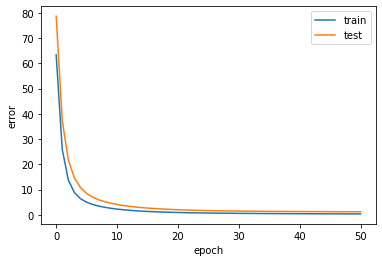

In [140]:
plt.plot(err_train)
plt.plot(err_test)
plt.xlabel('epoch')
plt.ylabel('error')
plt.legend({'train','test'})
plt.show()

## Conv Layer NTK

### Theory

We will assume the following network:
$$f(x) = u^T \sigma(w * x)$$
where $w$ is a convolution kernel with infinte number of channles, $[*]$ is the convolution operator, and sigma is also flatten.

In this case, we get the following kernel:
$$ K(x,x') = \mathbb{E}_{u,w} \left[ \sigma(w*x)\sigma(w*x') + \|u\|^2 \dot\sigma(w*x)\dot\sigma(w*x')q \cdot sum(x)sum(x') \rangle \right]$$
where $q$ is the size of the kernel (e.g. $q=9$ for $3\times 3$ kernel).